In [10]:
import json
with open('mag-cal3.txt') as f:
    r = []
    for l in f:
        try:
            r.append(json.loads(l))
        except BaseException:
            pass
r[0]


[10,
 [-0.08380005, -0.038308594, 10.328955],
 [0.006791061, 0.0041278997, 0.040480047],
 [628.80646, 115.07815, 255.7162],
 [[0.501666,
   0.8033002,
   0.2290499,
   -0.22489126,
   -0.006978478,
   -0.09722839,
   -0.011903575]]]

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20)

In [12]:
import numpy
mag = numpy.array([i[3] for i in r])

In [13]:
def draw(title, mag):
    plt.plot(mag[:, 0], mag[:, 1], mag[:, 1], mag[:, 2], mag[:, 2], mag[:, 0])
    plt.figlegend(["XY", "YZ", "ZX"])
    plt.title(title)

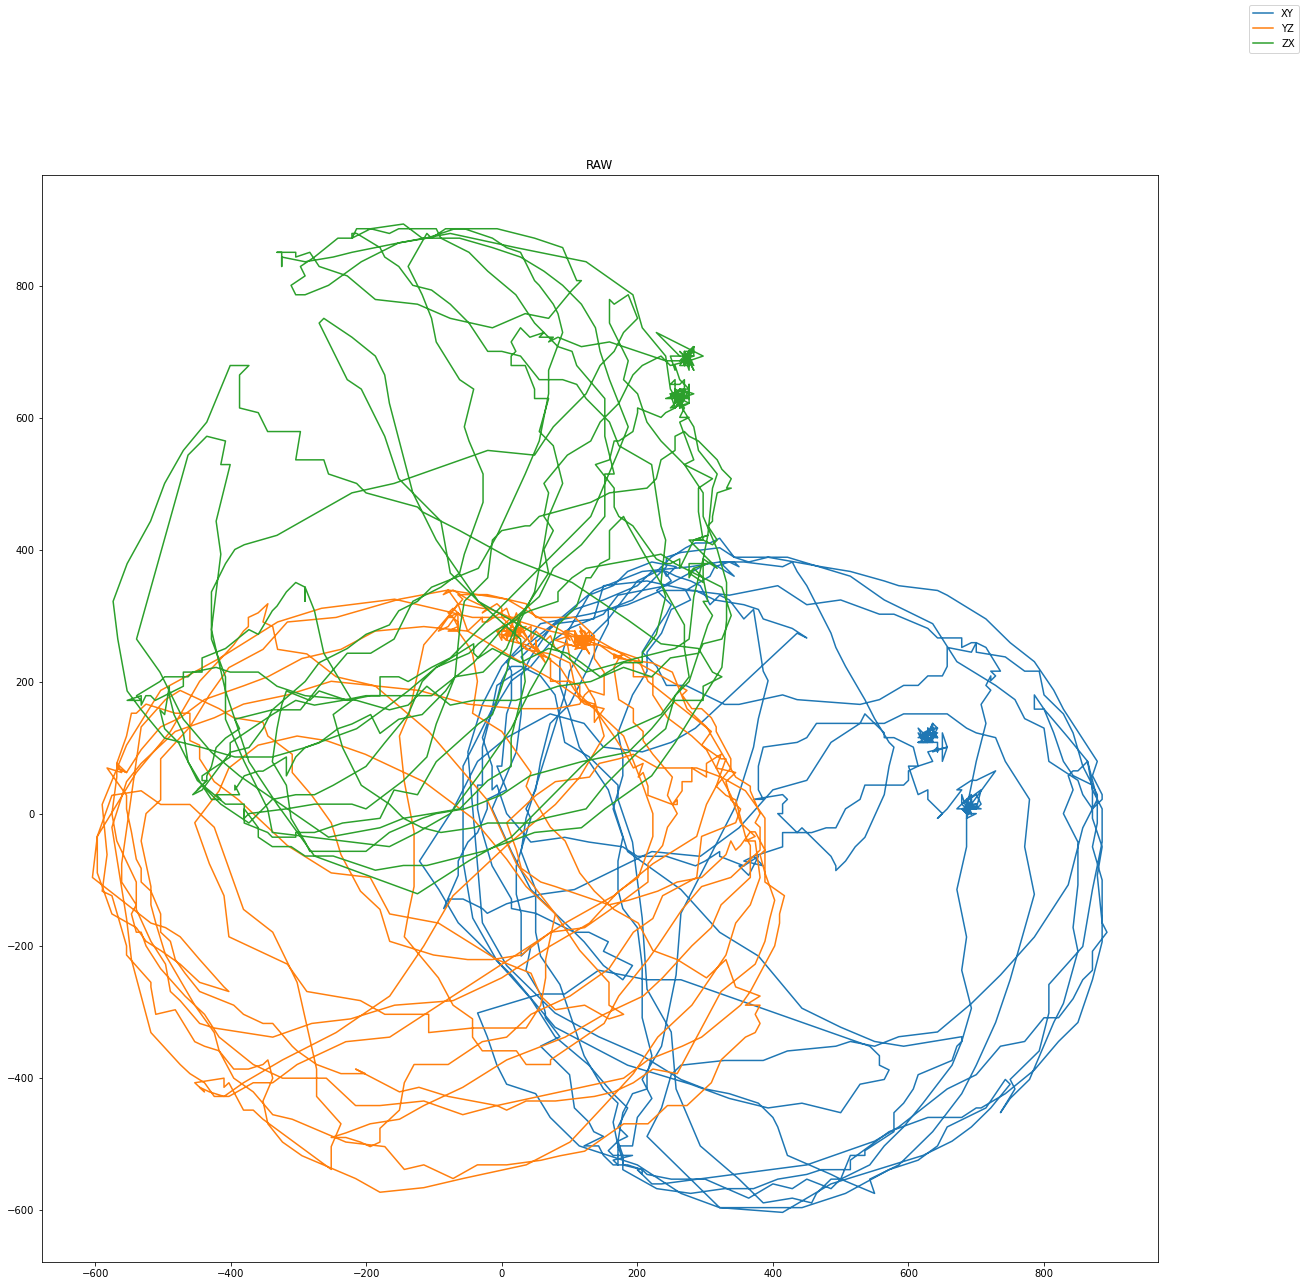

In [14]:
draw("RAW", mag)

In [15]:
bbox = numpy.max(mag, axis=0), numpy.min(mag, axis=0)
cal1 = bbox[1] + (bbox[0] - bbox[1]) / 2

In [16]:
mag_cal1 = mag - cal1

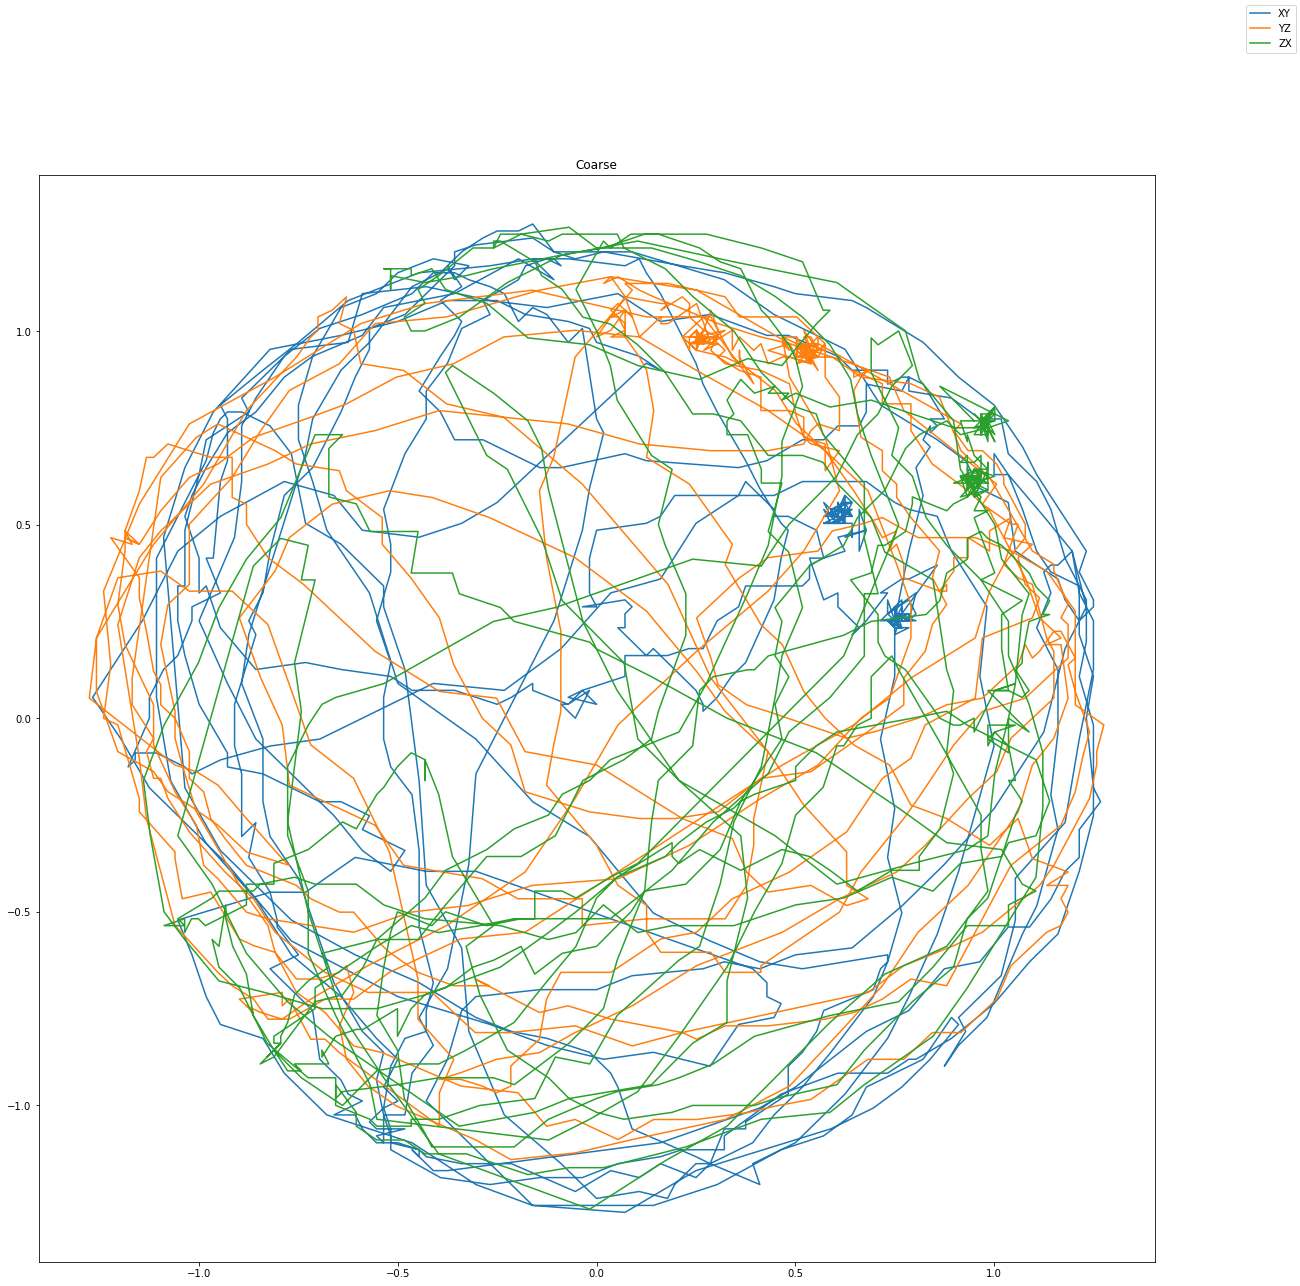

In [17]:
draw("Coarse", mag_cal1 / 400)

In [19]:
cal1

array([ 385.85853 ,  -93.50102 , -117.491245])

A_inv: 
[[ 2.02995940e-03  8.38754866e-06 -6.66594810e-05]
 [ 8.38754866e-06  2.02002864e-03  9.21912468e-05]
 [-6.66594810e-05  9.21912468e-05  2.17987104e-03]]

b
[[ 406.60833071]
 [ -92.11261908]
 [-114.73301431]]

Total Error: 10.175975


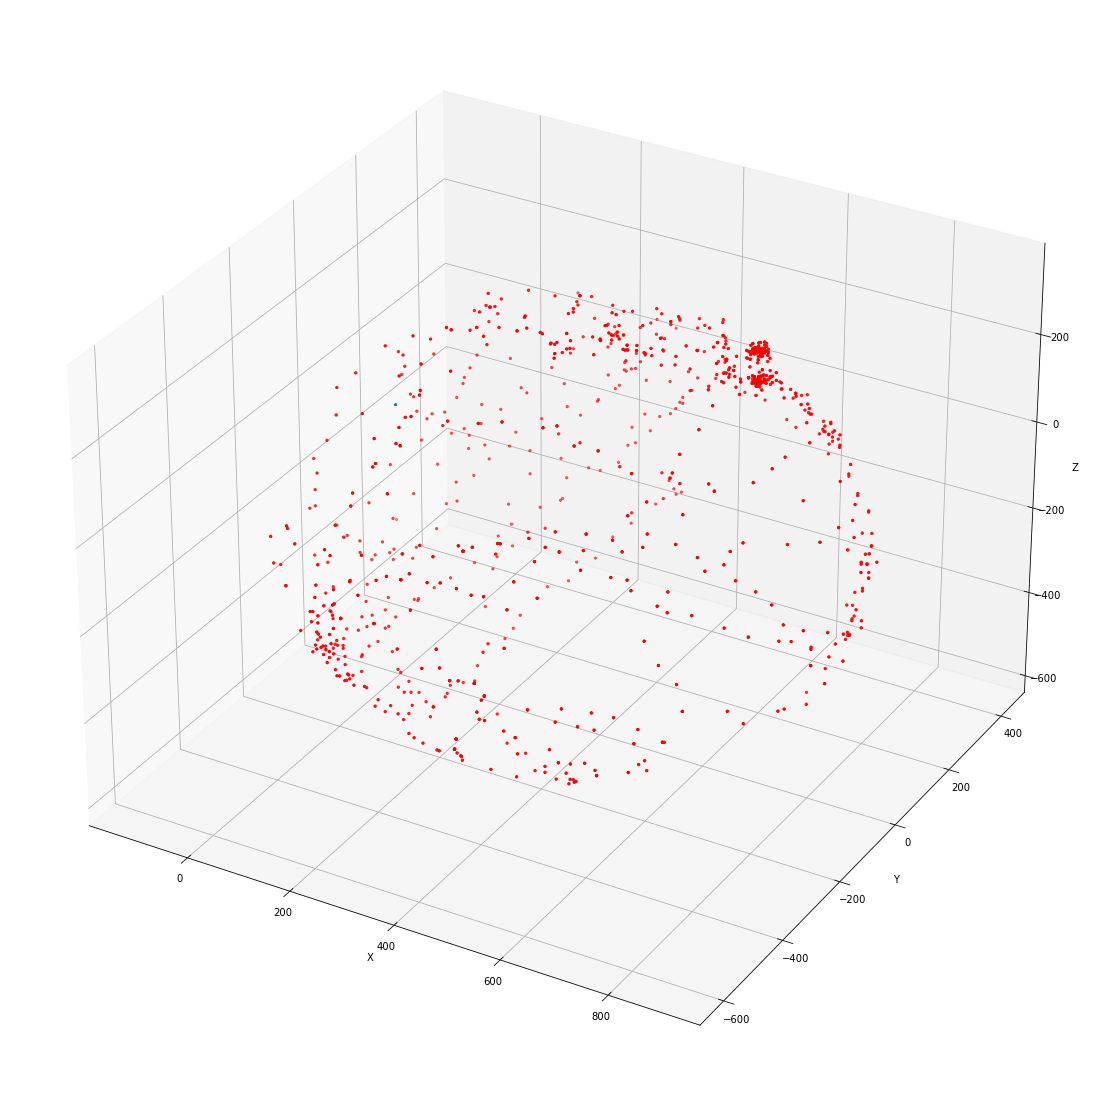

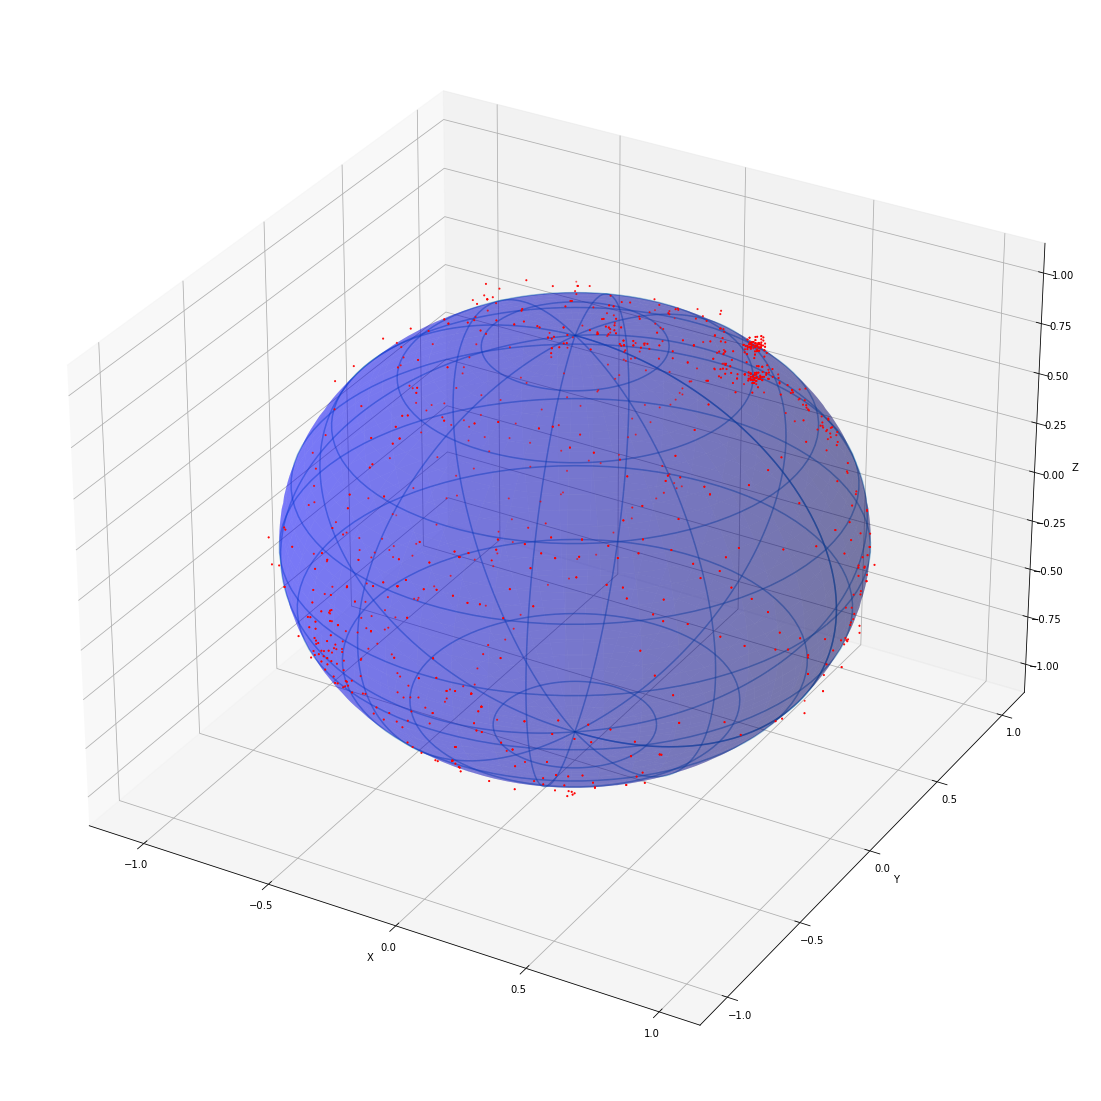

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg

def fitEllipsoid(magX, magY, magZ):
    a1 = magX ** 2
    a2 = magY ** 2
    a3 = magZ ** 2
    a4 = 2 * np.multiply(magY, magZ)
    a5 = 2 * np.multiply(magX, magZ)
    a6 = 2 * np.multiply(magX, magY)
    a7 = 2 * magX
    a8 = 2 * magY
    a9 = 2 * magZ
    a10 = np.ones(len(magX)).T
    D = np.array([a1, a2, a3, a4, a5, a6, a7, a8, a9, a10])

    # Eqn 7, k = 4
    C1 = np.array([[-1, 1, 1, 0, 0, 0],
                   [1, -1, 1, 0, 0, 0],
                   [1, 1, -1, 0, 0, 0],
                   [0, 0, 0, -4, 0, 0],
                   [0, 0, 0, 0, -4, 0],
                   [0, 0, 0, 0, 0, -4]])

    # Eqn 11
    S = np.matmul(D, D.T)
    S11 = S[:6, :6]
    S12 = S[:6, 6:]
    S21 = S[6:, :6]
    S22 = S[6:, 6:]

    # Eqn 15, find eigenvalue and vector
    # Since S is symmetric, S12.T = S21
    tmp = np.matmul(np.linalg.inv(C1), S11 - np.matmul(S12, np.matmul(np.linalg.inv(S22), S21)))
    eigenValue, eigenVector = np.linalg.eig(tmp)
    u1 = eigenVector[:, np.argmax(eigenValue)]

    # Eqn 13 solution
    u2 = np.matmul(-np.matmul(np.linalg.inv(S22), S21), u1)

    # Total solution
    u = np.concatenate([u1, u2]).T

    Q = np.array([[u[0], u[5], u[4]],
                  [u[5], u[1], u[3]],
                  [u[4], u[3], u[2]]])

    n = np.array([[u[6]],
                  [u[7]],
                  [u[8]]])

    d = u[9]

    return Q, n, d

def kalbirete(data):
    data = np.array([i[3] for i in r])
    magX = data[:, 0]
    magY = data[:, 1]
    magZ = data[:, 2]

    fig1 = plt.figure(1)
    ax1 = fig1.add_subplot(111, projection='3d')

    ax1.scatter(magX, magY, magZ, s=5, color='r')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # plot unit sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax1.plot_wireframe(x, y, z, rstride=10, cstride=10, alpha=0.5)
    ax1.plot_surface(x, y, z, alpha=0.3, color='b')

    Q, n, d = fitEllipsoid(magX, magY, magZ)

    Qinv = np.linalg.inv(Q)
    b = -np.dot(Qinv, n)
    Ainv = np.real(1 / np.sqrt(np.dot(n.T, np.dot(Qinv, n)) - d) * linalg.sqrtm(Q))

    print("A_inv: ")
    print(Ainv)
    print()
    print("b")
    print(b)
    print()

    calibratedX = np.zeros(magX.shape)
    calibratedY = np.zeros(magY.shape)
    calibratedZ = np.zeros(magZ.shape)

    totalError = 0
    for i in range(len(magX)):
        h = np.array([[magX[i], magY[i], magZ[i]]]).T
        hHat = np.matmul(Ainv, h-b)
        calibratedX[i] = hHat[0]
        calibratedY[i] = hHat[1]
        calibratedZ[i] = hHat[2]
        mag = np.dot(hHat.T, hHat)
        err = (mag[0][0] - 1)**2
        totalError += err
    print("Total Error: %f" % totalError)

    fig2 = plt.figure(2)
    ax2 = fig2.add_subplot(111, projection='3d')

    ax2.scatter(calibratedX, calibratedY, calibratedZ, s=1, color='r')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # plot unit sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax2.plot_wireframe(x, y, z, rstride=10, cstride=10, alpha=0.5)
    ax2.plot_surface(x, y, z, alpha=0.3, color='b')
    plt.show()

kalbirete(r)